In [97]:
# import sys
# !{sys.executable} -m pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Get data

In [2]:
df = pd.read_csv('./../../labeledTweets/allLabeledTweets.csv')
df = df[['id', 'message', 'label']]
df.head()

,id,message,label
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0


In [3]:
df['label'].value_counts()

0    968
2    647
1    410
Name: label, dtype: int64

In [4]:
newLine ="\\n|\\r"
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+((\.|\-)\d+)?'
mentions = '\B\@([\w\-]+)'
hashtag = '#'
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

df['clean_message'] = df['message']
df['clean_message'] = df['clean_message'].str.replace(newLine,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(urls,' URL ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(mentions,' MENTION ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(numbers,' NMBR ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(hashtag,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(whitespaces,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(leadTrailWhitespace,'',regex=True)

df.head()

,id,message,label,clean_message
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: airBaltic “potenciālie pircēji ir no ...
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,MENTION MENTION MENTION Netrāpīs kādam AirBalt...


# Train, validate split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [6]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message  clean_message
label data_type                             
0     train      823      823            823
      val        145      145            145
1     train      348      348            348
      val         62       62             62
2     train      550      550            550
      val         97       97             97

In [7]:
df.head()

,id,message,label,clean_message,data_type
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...,train
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: airBaltic “potenciālie pircēji ir no ...,val
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...,train
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...,train
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,MENTION MENTION MENTION Netrāpīs kādam AirBalt...,train


## Balance training data

In [8]:
df[df.data_type=='train']['label'].value_counts()

0    823
2    550
1    348
Name: label, dtype: int64

In [9]:
df[df.data_type=='train'].head()

,id,message,label,clean_message,data_type
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...,train
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...,train
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...,train
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,MENTION MENTION MENTION Netrāpīs kādam AirBalt...,train
5,1481060,airBaltic uzsāks lidojumus uz Sočiem un Kaļiņi...,0,airBaltic uzsāks lidojumus uz Sočiem un Kaļiņi...,train


In [10]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_1.shape[0], random_state=42)
df_2_downsampled = df_2.sample(df_1.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_2_downsampled, df_1])

df_train['label'].value_counts()

0    348
1    348
2    348
Name: label, dtype: int64

In [11]:
df_train.head()

,clean_message,label
1526,"MENTION Sveiki! Lūdzu, atsūti DM savu pieslēgu...",0
567,Tiešraide jau pēc NMBR minūtēm! MENTION - MENT...,0
260,"ES ATVAINOJOS, VAI IR KĀDS IZDEVĪGĀKS PAR LATV...",0
560,Tiešraide jau pēc NMBR minūtēm! MENTION - HK P...,0
777,SEB ievieš Latvijā pirmo indeksu plānu pensiju...,0


In [12]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
700,Šodien norisinās SEB MTB maratons. Finišs MENT...,0
1911,MENTION Sveiks! Tas neattiecas uz mūsu ekspert...,1
505,"MENTION MENTION Starpcitu, Maxima tirgo labus ...",1
1471,Taisnība ir uzvarējusi! Martins Dukurs kļūst p...,1
1537,MENTION Спасибо за мнение.^el,0


# Tokenizer "sentence-transformers/LaBSE"

In [34]:
tokenizer = AutoTokenizer.from_pretrained("./../labse_bert_model", do_lower_case=True)

## Find popular UNK tokens

In [14]:
unk_tokens = []
for message in df.clean_message.values:
    list_of_space_separated_pieces = message.strip().split()
    ids = [tokenizer(piece, add_special_tokens=False, max_length=1011)["input_ids"] for piece in list_of_space_separated_pieces]
    unk_indices = [i for i, encoded in enumerate(ids) if tokenizer.unk_token_id in encoded]
    unknown_strings = [piece for i, piece in enumerate(list_of_space_separated_pieces) if i in unk_indices]
    for unk_str in unknown_strings:
        unk_tokens.append(unk_str)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [15]:
import collections

counter=collections.Counter(unk_tokens)
print(counter.most_common(100))

most_common_values= [word for word, word_count in counter.most_common(100)]
print(most_common_values)

[('🤬', 2), ('🇷🇺🤥', 1), ('🤷🏼\u200d♂️🤦🏼\u200d♂️🕵🏼\u200d♂️😂', 1), ('🤢🤑', 1), ('🏎️', 1), ('🖼️', 1), ('🔌', 1)]
['🤬', '🇷🇺🤥', '🤷🏼\u200d♂️🤦🏼\u200d♂️🕵🏼\u200d♂️😂', '🤢🤑', '🏎️', '🖼️', '🔌']


In [35]:
c=[('🥴', 823), ('\U0001f972', 277), ('🤬', 267), ('\U0001f90d', 242), ('🤢', 113), ('🥶', 112), ('\U0001fa78', 108), ('🤮', 105), ('🤧', 98), ('🥵', 98), ('🧸', 91), ('\U0001f971', 90), ('🧿', 88), ('🖕', 85), ('𝔢', 82), ('⚾', 58), ('🌑', 56), ('🤟', 54), ('𝔦', 47), ('\U0001f978', 44), ('\U0001f90e', 44), ('🗳', 42), ('𝔱', 40), ('🧢', 39), ('𝔞', 37), ('🥃', 35), ('🗑', 33), ('\U0001f9cd', 32), ('🆘', 32), ('🧔', 31), ('🦠', 29), ('🥊', 27), ('🦃', 27), ('⛽', 26), ('𝔫', 26), ('𝔯', 25), ('𝔰', 23), ('𝔣', 22), ('🦍', 21), ('♾', 21), ('🥴.', 20), ('\U0001f90c', 20), ('𝚎', 20), ('🧟', 19), ('🐤', 18), ('🖐', 18), ('🤚', 18), ('🚮', 18), ('🥴,', 17), ('𝕖', 17), ('🛸', 17), ('🌮', 17), ('𝑒', 17), ('🦌', 16), ('🖖', 16), ('𝐚', 16), ('𝗶', 16), ('🥩', 15), ('👺', 15), ('🤛', 15), ('🧖', 15), ('𝔬', 15), ('𝐢', 14), ('😿', 14), ('𝒊', 14), ('𝒆', 14), ('𝘀', 14), ('🦉', 14), ('𝚝', 14), ('𝚘', 14), ('🛏', 14), ('𝔤', 14), ('𝔥', 14), ('𝐞', 13), ('🆙', 13), ('𝒏', 13), ('🧁', 13), ('🔌', 13), ('🧑', 13), ('🍖', 13), ('𝚜', 13), ('𝚒', 13), ('🚦', 13), ('\U0001fab4', 13), ('🤒', 12), ('👃', 12), ('🎟', 12), ('🤜', 12), ('🥤', 12), ('\U0001fa90', 12), ('𝕠', 12), ('🌨', 12), ('𝙤', 12), ('𝚕', 12), ('𝔩', 12), ('𝚊', 12), ('🕎', 11), ('𝒕', 11), ('🕷', 11), ('👂', 11)]
most_common_values= [word for word, word_count in c]

In [36]:
tokenizer.add_tokens(most_common_values, special_tokens=True)

100

### Find max length for tokenizer

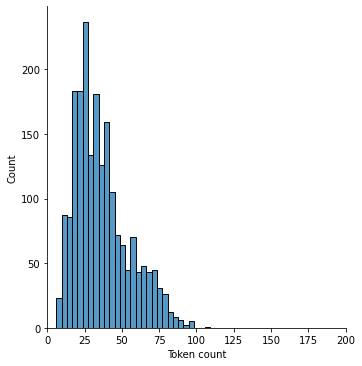

In [37]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')
plt.show()

In [38]:
max_length = 120

### Encode messages

In [39]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\aligo\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [40]:
len(dataset_train), len(dataset_val)

(1044, 304)

In [19]:
# torch.save(dataset_train, './datasetsLowercase/dataset_train.pt')
# torch.save(dataset_val, './datasetsLowercase/dataset_val.pt')

In [20]:
# dataset_train = torch.load('./datasetsLowercase/dataset_train.pt')
# dataset_val = torch.load('./datasetsLowercase/dataset_val.pt')

In [21]:
# len(dataset_train), len(dataset_val)

# Model "LaBSE" pytorch

In [41]:
model = AutoModelForSequenceClassification.from_pretrained("./../labse_bert_model", num_labels = 3)

Some weights of the model checkpoint at ./../labse_bert_model were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

In [42]:
model.resize_token_embeddings(len(tokenizer))

Embedding(501253, 768)

In [43]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [44]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [45]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [46]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [47]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model.to(device)
print(device)

cpu


In [48]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    progress_bar = tqdm(dataloader_val, desc='Validating:', leave=False, disable=False)
    for batch in progress_bar:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Evaluate model trained on PNN dataset on LV Twitter data

In [49]:
model.load_state_dict(torch.load('modelsUNK-pnn/finetuned_LaBSE_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [50]:
_, predictions, true_vals = evaluate(dataloader_validation)

from sklearn.metrics import classification_report, confusion_matrix

preds_flat = np.argmax(predictions, axis=1).flatten()

print(classification_report(true_vals, preds_flat))
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

Validating::   0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.50      0.40      0.44       145
           1       0.29      0.56      0.38        62
           2       0.30      0.21      0.24        97

    accuracy                           0.37       304
   macro avg       0.36      0.39      0.36       304
weighted avg       0.39      0.37      0.37       304



predicted                  
                  neutral positive negative
actual neutral         58       56       31
       positive        11       35       16
       negative        47       30       20

# Train on Latvian Twitter data

In [51]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'modelsUNKTwttrPNN/finetuned_LaBSE_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0130393559282476


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.9101784229278564
F1 Score (Weighted): 0.6159219805188928
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.57      0.64       145
           1       0.46      0.61      0.53        62
           2       0.59      0.68      0.63        97

    accuracy                           0.61       304
   macro avg       0.60      0.62      0.60       304
weighted avg       0.64      0.61      0.62       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         82       30       33
       positive        11       38       13
       negative        17       14       66


Epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8354363405343258


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.8673094213008881
F1 Score (Weighted): 0.619566040049033
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.57      0.65       145
           1       0.43      0.73      0.54        62
           2       0.64      0.60      0.62        97

    accuracy                           0.61       304
   macro avg       0.61      0.63      0.60       304
weighted avg       0.66      0.61      0.62       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         83       39       23
       positive         8       45        9
       negative        18       21       58


Epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.7344294334902908


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.7796196639537811
F1 Score (Weighted): 0.6542570719899122
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       145
           1       0.51      0.69      0.59        62
           2       0.67      0.59      0.63        97

    accuracy                           0.65       304
   macro avg       0.64      0.65      0.64       304
weighted avg       0.67      0.65      0.65       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         98       27       20
       positive        11       43        8
       negative        25       15       57


Epoch 4:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.6639275325067115


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.7844478011131286
F1 Score (Weighted): 0.6489066472083609
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.60      0.67       145
           1       0.49      0.74      0.59        62
           2       0.64      0.65      0.65        97

    accuracy                           0.64       304
   macro avg       0.64      0.66      0.64       304
weighted avg       0.67      0.64      0.65       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         87       32       26
       positive         7       46        9
       negative        19       15       63


Epoch 5:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.6244907388181398


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.781890457868576
F1 Score (Weighted): 0.6554352853773867
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.62      0.68       145
           1       0.50      0.74      0.60        62
           2       0.66      0.64      0.65        97

    accuracy                           0.65       304
   macro avg       0.64      0.67      0.64       304
weighted avg       0.68      0.65      0.66       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         90       32       23
       positive         7       46        9
       negative        21       14       62


# Evaluate

In [210]:
model.load_state_dict(torch.load('modelsBaseTwttrPNN/finetuned_BERT_epoch_X.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
preds_flat = np.argmax(predictions, axis=1).flatten()

In [ ]:
print(classification_report(true_vals, preds_flat))

In [ ]:
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])